## Setup

Using [`pretty_midi`](https://github.com/craffel/pretty-midi) library to create and parse MIDI files, and [`pyfluidsynth`](https://github.com/nwhitehead/pyfluidsynth) for generating audio playback in Colab.

In [1]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin
  libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5
  libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslations5-l10n
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libevdev2 libfluidsynth3 libgudev-1.0-0
  libinput-bin libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a
  libqt5dbus5 libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libx

In [2]:
!pip install --upgrade pyfluidsynth

In [3]:
!pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 6.6 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592284 sha256=3a6eb2a9493856c50318c6113b529cfda56c5f2de856fd67e2b6c1df5e31ebd4
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi


In [4]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from tensorflow.keras import regularizers

In [5]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

## Downloading the Bach dataset

In [7]:
import gdown
import shutil
import os
from zipfile import ZipFile

file_id = '1WalUeZ-4Xv0VIFUKtvZ2KWmxUt-1IyVT'
zip_file_name = 'dataset.zip'

# Download the file using gdown
url = f'https://drive.google.com/uc?id={file_id}'
gdown.download(url, zip_file_name, quiet=False)

# Extract the contents of the zip file
with ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

# Remove the zip file
os.remove(zip_file_name)


Downloading...
From: https://drive.google.com/uc?id=1WalUeZ-4Xv0VIFUKtvZ2KWmxUt-1IyVT
To: /content/dataset.zip
100%|██████████| 12.3M/12.3M [00:00<00:00, 31.1MB/s]


In [8]:
filenames = glob.glob(str("dataset/test/"'*.mid*'))
print('Number of files:', len(filenames))

Number of files: 4000


In [9]:
filenamestrain = glob.glob(str("dataset/train/"'*.mid*'))
print('Number of files:', len(filenamestrain))

Number of files: 16000


## Processing a MIDI file

```pretty_midi``` is used to parse a single MIDI file and inspect the format of the notes. Can write ```files.download(sample_file)``` to download midi file to use on computer.


In [10]:
sample_file = filenames[5]
print(sample_file)

dataset/test/3907.mid


Generating a `PrettyMIDI` object for the sample MIDI file.

In [11]:
pm = pretty_midi.PrettyMIDI(sample_file)

Playing sample file (may take a few seconds)

In [12]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [13]:
display_audio(pm)

Inspection on the MIDI file with instrument used

In [14]:
print('Number of instruments:', len(pm.instruments))

for i, instrument in enumerate(pm.instruments):
  instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
  print('Instrument', i+1,'name:', instrument_name)

Number of instruments: 4
Instrument 1 name: Trumpet
Instrument 2 name: French Horn
Instrument 3 name: Trombone
Instrument 4 name: Tuba


## Extracting notes

In [15]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=56, note_name=G#3, duration=1.1925
1: pitch=57, note_name=A3, duration=1.1975
2: pitch=50, note_name=D3, duration=1.2000
3: pitch=52, note_name=E3, duration=1.1800
4: pitch=54, note_name=F#3, duration=1.2000
5: pitch=59, note_name=B3, duration=1.2000
6: pitch=57, note_name=A3, duration=1.1925
7: pitch=62, note_name=D4, duration=2.4000
8: pitch=61, note_name=C#4, duration=1.1925
9: pitch=62, note_name=D4, duration=1.1750


Three variables to represent a note when training the model: `pitch`, `step` and `duration`. The pitch is the perceptual quality of the sound as a MIDI note number.
The `step` is the time elapsed from the previous note or start of the track.
The `duration` is how long the note will be playing in seconds and is the difference between the note end and note start times.


Extracting notes from the sample MIDI file.

In [16]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  notes = collections.defaultdict(list)

  sorted_notes = []
  # Sort the notes by start time
  for instrument in pm.instruments:
    sorted_notes += sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [17]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,76,0.0100,1.2100,0.0000,1.2000
1,73,1.2100,2.3950,1.2000,1.1850
2,71,2.3950,4.7950,1.1850,2.4000
3,69,4.8000,5.9825,2.4050,1.1825
4,74,5.9825,7.1825,1.1825,1.2000


Function to convert from the numeric pitch values to note names.
The note name shows the type of note, accidental and octave number
(e.g. C#4).

In [18]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['E5', 'C#5', 'B4', 'A4', 'D5', 'E5', 'F#5', 'G5', 'A5', 'F#5'],
      dtype='<U3')

Visualizing the musical piece, plotting the note pitch, start and end across the length of the track (i.e. piano roll). Starting with the first 100 notes

In [19]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

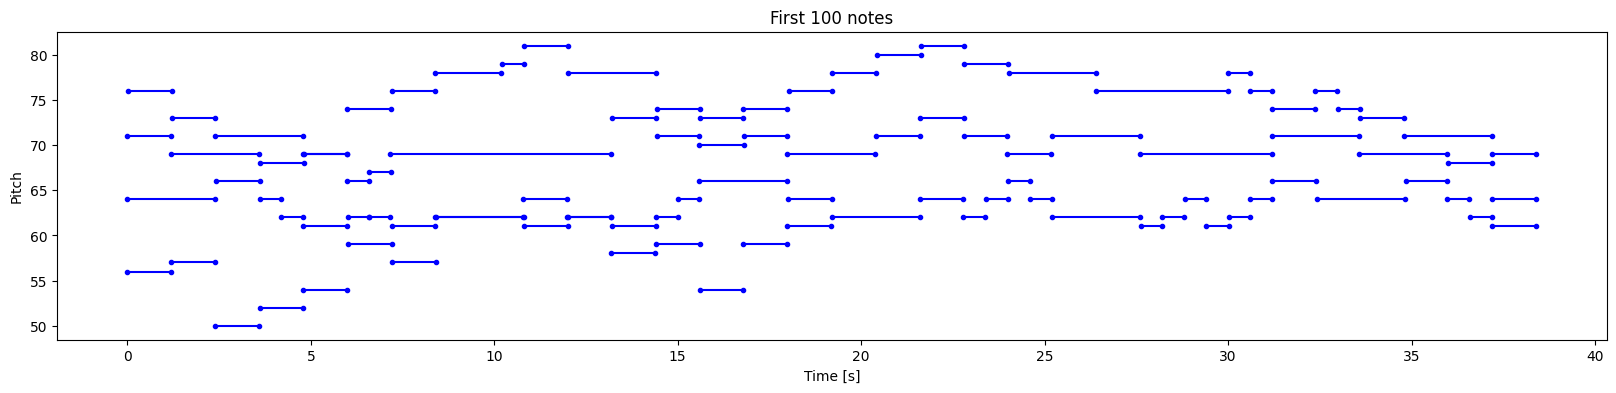

In [20]:
plot_piano_roll(raw_notes, count=100)

Plot the notes for the entire track.

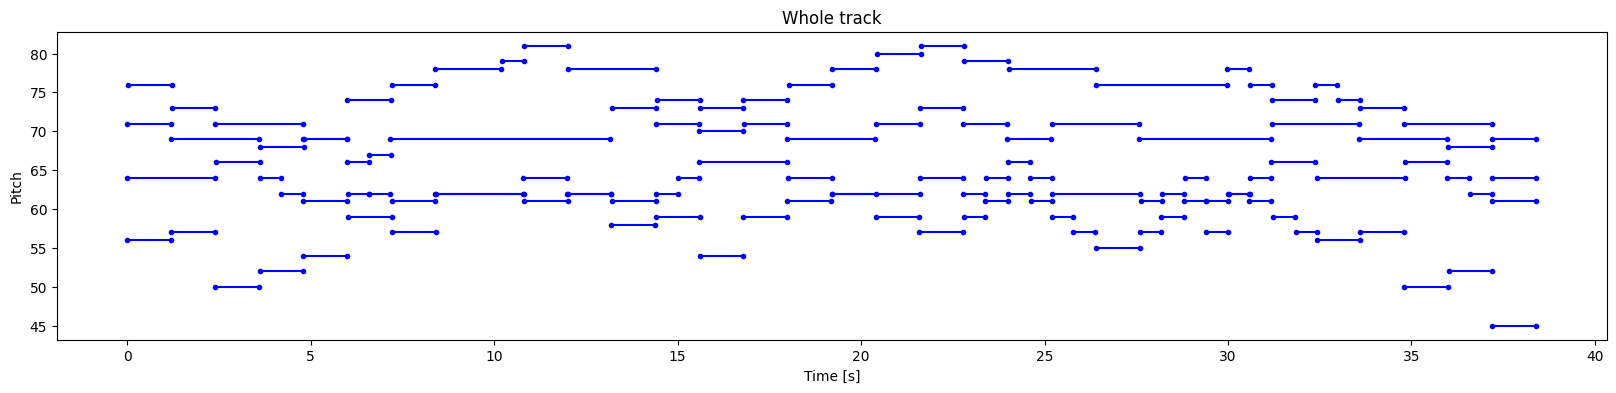

In [21]:
plot_piano_roll(raw_notes)

Check the distribution of each note variable.

In [22]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

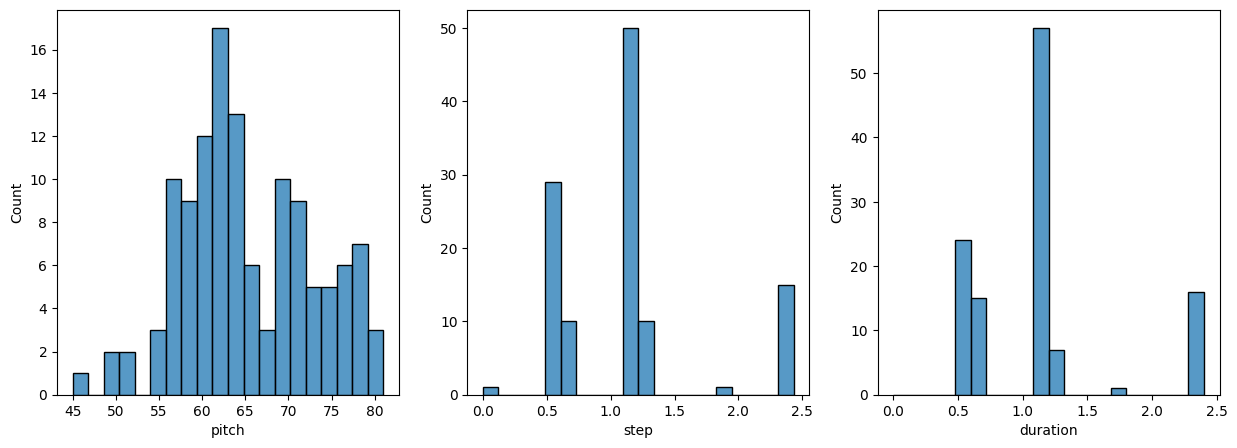

In [23]:
plot_distributions(raw_notes)

## Create a MIDI file

Generate MIDI file from a list of notes, convert all instruments to a single piano track for simplicity


In [24]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str,
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          'Acoustic Grand Piano'))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [25]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

## Create the training dataset


Creating the training dataset by extracting notes from the MIDI files. Start by using a small number of files, and experiment later with more.

In [46]:
num_files = 1000
all_notes = []
for f in filenamestrain[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

#and the test set
num_files = 200
all_notes_test = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes_test.append(notes)

all_notes_test = pd.concat(all_notes_test)

In [47]:
n_notes = len(all_notes)
print('Number of notes parsed for training:', n_notes)

n_notes_test = len(all_notes_test)
print('Number of notes parsed for testing:', n_notes_test)

Number of notes parsed for training: 94446
Number of notes parsed for testing: 19421


Create a `tf.data.Dataset` from the parsed notes.

In [48]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)
test_notes = np.stack([all_notes_test[key] for key in key_order], axis=1)

In [49]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
print(notes_ds.element_spec)

notes_ds_test = tf.data.Dataset.from_tensor_slices(test_notes)
print(notes_ds_test.element_spec)

TensorSpec(shape=(3,), dtype=tf.float64, name=None)
TensorSpec(shape=(3,), dtype=tf.float64, name=None)


Training the model on batches of sequences of notes. Each example will consist of a sequence of notes as the input features, and the next note as the label. In this way, the model will be trained to predict the next note in a sequence. Diagram describing this process: [Text classification with an RNN](https://www.tensorflow.org/text/tutorials/text_generation).

 The [window](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#window) function with size `seq_length` can be used to create the features and labels in this format.

In [50]:
def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

Setting the sequence length for each example. Can experiment with different lengths (e.g. 50, 100, 150) to see which one works best for the data, or use [hyperparameter tuning](https://www.tensorflow.org/tutorials/keras/keras_tuner). The size of the vocabulary (`vocab_size`) is set to 128 representing all the pitches supported by `pretty_midi`.

In [51]:
seq_length = 50
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

seq_ds_test = create_sequences(notes_ds_test, seq_length, vocab_size)
seq_ds_test.element_spec

(TensorSpec(shape=(50, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

The shape of the dataset is ```(100,1)```, meaning that the model will take 100 notes as input, and learn to predict the following note as output.

In [52]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (50, 3)
sequence elements (first 10): tf.Tensor(
[[0.5546875  0.         0.74519059]
 [0.59375    0.74519059 0.76762644]
 [0.578125   0.76762644 1.538458  ]
 [0.5703125  1.54807336 0.75801108]
 [0.5390625  0.75801108 0.769229  ]
 [0.5546875  0.78204948 0.75961364]
 [0.5703125  0.75961364 0.769229  ]
 [0.578125   0.77563924 0.769229  ]
 [0.59375    0.77243412 0.76442132]
 [0.609375   0.76442132 1.538458  ]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=66.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=1.5336503187499986>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.7692289999999993>}


Batch the examples, and configure the dataset for performance.

In [53]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

test_ds = (seq_ds_test
           .batch(batch_size, drop_remainder=True)
           .cache()
           .prefetch(tf.data.experimental.AUTOTUNE))

In [54]:
train_ds.element_spec

(TensorSpec(shape=(64, 50, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

## Create and train the model

The model will have three outputs, one for each note variable. For `step` and `duration`, there is a loss function based on mean squared error that encourages the model to output non-negative values.

The loss functions measure the midi both forwards and backwards. Forward is prioritized.

In [118]:
def reverse_notes(notes):
  end = notes['end'].max()

  for note in notes:
    temp = note['start']
    note['start'] = end - note['end']
    note['end'] = end - note['start']

  return notes

In [119]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)

  y_pred = tf.reverse(y_pred, axis=[0])

  rmse = (y_true - y_pred) ** 2
  rpositive_pressure = 10 * tf.maximum(-y_pred, 0.0)


  return tf.reduce_mean(mse + positive_pressure) + 0.5*(tf.reduce_mean(rmse + rpositive_pressure))



# for pitch, we want to encourage diversity thus we add a loss penalty to the model for not having enough diversity of notes

def pitch_loss(y_true: tf.Tensor, y_pred: tf.Tensor):
  original_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)

  prob = tf.nn.softmax(y_pred)
  entropy = -tf.reduce_sum(prob * tf.math.log(prob), axis=1)

  alpha = 0.01

  y_pred = tf.reverse(y_pred, axis=[0])

  roriginal_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)
  rprob = tf.nn.softmax(y_pred)
  rentropy = -tf.reduce_sum(prob * tf.math.log(prob), axis=1)

  return (original_loss + alpha * entropy) + 0.5*(roriginal_loss + alpha * rentropy)

In [120]:
input_shape = (seq_length, 3)
#learning_rate = 0.0025 #original 0.005


def learning_rate_schedule(epoch):
    if epoch < 30:
        return 0.005
    elif epoch < 50:
        return 0.001
    else:
        return 0.0005

learning_rate = tf.keras.callbacks.LearningRateScheduler(learning_rate_schedule, )

lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                                  factor=np.sqrt(0.1),
                                                  cooldown=0,
                                                  patience=10,
                                                  min_lr=0.5e-6)

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': pitch_loss,
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=0.005) #orignal learning rate

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 50, 3)]              0         []                            
                                                                                                  
 lstm_6 (LSTM)               (None, 128)                  67584     ['input_7[0][0]']             
                                                                                                  
 duration (Dense)            (None, 1)                    129       ['lstm_6[0][0]']              
                                                                                                  
 pitch (Dense)               (None, 128)                  16512     ['lstm_6[0][0]']              
                                                                                            

Now we can see what the loss is and the individual losses for duration, pitch and step.


In [121]:
losses = model.evaluate(train_ds, return_dict=True)
losses

1474/1474 [==============================] - 6s 3ms/step - loss: 33.3904 - duration_loss: 2.4795 - pitch_loss: 7.3644 - step_loss: 23.5465


{'loss': 33.39036178588867,
 'duration_loss': 2.4794816970825195,
 'pitch_loss': 7.364357948303223,
 'step_loss': 23.54652214050293}

We can see that step loss dominates the losses, skewing the total loss. duration loss is almost unimportant to the final loss function which, in our testing, led to tracks where every note was the exact same length. This isn't always bad, note duration is relatively consistant, but it would be better if we could train our model so that it computes the changes from all the losses more fairly.

Therefore we use the `loss_weights` argument to compile. This allows us to weigh each of the losses and give a more accurate persepctive loss.

In [122]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.6,
        'step': 0.03,
        'duration':1.1,
        #give half as much weight to the reverse (prioritize it sounding good forward)
        #'reverse_pitch': 0.3,
        #'reverse_step': 0.015,
        #'reverse_duration': 0.55,
    },
    optimizer=optimizer,
)

The `loss` then becomes the weighted sum of the individual losses. Meaning each of the loss functions becomes equally important to the model

1.   List item
2.   List item



In [123]:
model.evaluate(train_ds, return_dict=True)

1474/1474 [==============================] - 6s 3ms/step - loss: 7.8524 - duration_loss: 2.4795 - pitch_loss: 7.3644 - step_loss: 23.5465


{'loss': 7.85244083404541,
 'duration_loss': 2.4794816970825195,
 'pitch_loss': 7.364357948303223,
 'step_loss': 23.54652214050293}

Use hyperparameter tuning to find the best value for seq length

In [281]:
"""
hyperparams = {
    'seq_length': [16, 32, 64, 128, 256],
}

grid_search = RandomizedSearchCV(model, hyperparams, n_iter=100, scoring='f1_macro')

grid_search.fit(X=train_ds, y=test_ds, epochs=100)

print(grid_search.best_params_)
"""

"\nhyperparams = {\n    'seq_length': [16, 32, 64, 128, 256],\n}\n\ngrid_search = RandomizedSearchCV(model, hyperparams, n_iter=100, scoring='f1_macro')\n\ngrid_search.fit(X=train_ds, y=test_ds, epochs=100)\n\nprint(grid_search.best_params_)\n"

Train the model.

In [124]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=30,
        verbose=1,
        restore_best_weights=True),
    lr_reducer,
    learning_rate,
]

In [125]:
%%time
epochs = 100

history = model.fit(
    train_ds,
    verbose=1,
    validation_data=test_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/100
1474/1474 [==============================] - 11s 6ms/step - loss: 4.9503 - duration_loss: 1.2130 - pitch_loss: 4.8815 - step_loss: 22.9014 - val_loss: 4.5559 - val_duration_loss: 0.9578 - val_pitch_loss: 4.8226 - val_step_loss: 20.2911 - lr: 0.0050
Epoch 2/100
1474/1474 [==============================] - 9s 6ms/step - loss: 4.8219 - duration_loss: 1.1848 - pitch_loss: 4.7385 - step_loss: 22.5188 - val_loss: 4.5095 - val_duration_loss: 0.9467 - val_pitch_loss: 4.7626 - val_step_loss: 20.3546 - lr: 0.0050
Epoch 3/100
1474/1474 [==============================] - 9s 6ms/step - loss: 4.7716 - duration_loss: 1.1704 - pitch_loss: 4.6894 - step_loss: 22.3493 - val_loss: 4.4799 - val_duration_loss: 0.9396 - val_pitch_loss: 4.7321 - val_step_loss: 20.2346 - lr: 0.0050
Epoch 4/100
1474/1474 [==============================] - 9s 6ms/step - loss: 4.7465 - duration_loss: 1.1617 - pitch_loss: 4.6689 - step_loss: 22.2419 - val_loss: 4.4429 - val_duration_loss: 0.9332 - val_pitch_loss: 4.69

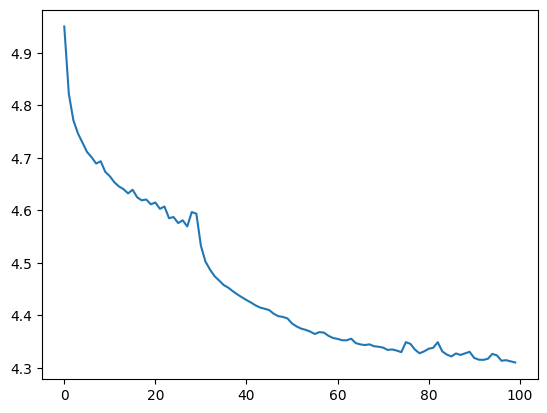

In [126]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

## Generate notes

To use the model to generate notes, it first needs a starting sequence of notes. The function below generates one note from a sequence of notes.

For note pitch, it draws a sample from the softmax distribution of notes produced by the model, and does not simply pick the note with the highest probability. Highest probability would lead to repetitive notes.

The `temperature` parameter can be used to control the randomness of notes generated.

In [127]:
def predict_next_note(
    notes: np.ndarray,
    model: tf.keras.Model,
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

Generating some notes. Can manipulate temperature and the starting sequence in `next_notes`

In [134]:
temperature = 2
num_predictions = 128

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 18ms/step


In [135]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,66,0.000000,1.603623,0.000000,1.603623
1,79,1.128013,0.707624,1.128013,1.835636
2,81,1.375415,0.893658,2.503427,3.397085
3,79,1.449125,0.924610,3.952552,4.877162
4,63,1.413444,0.905038,5.365996,6.271033
5,81,1.410201,0.925163,6.776196,7.701359
6,80,1.414296,0.941239,8.190492,9.131731
7,81,1.472542,0.985176,9.663034,10.648210
8,78,1.463716,0.964927,11.126749,12.091676
9,78,1.473426,0.994864,12.600175,13.595039


In [136]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

To download the generated midi file

In [ ]:
from google.colab import files
files.download(out_file)

Visualize the generated notes.

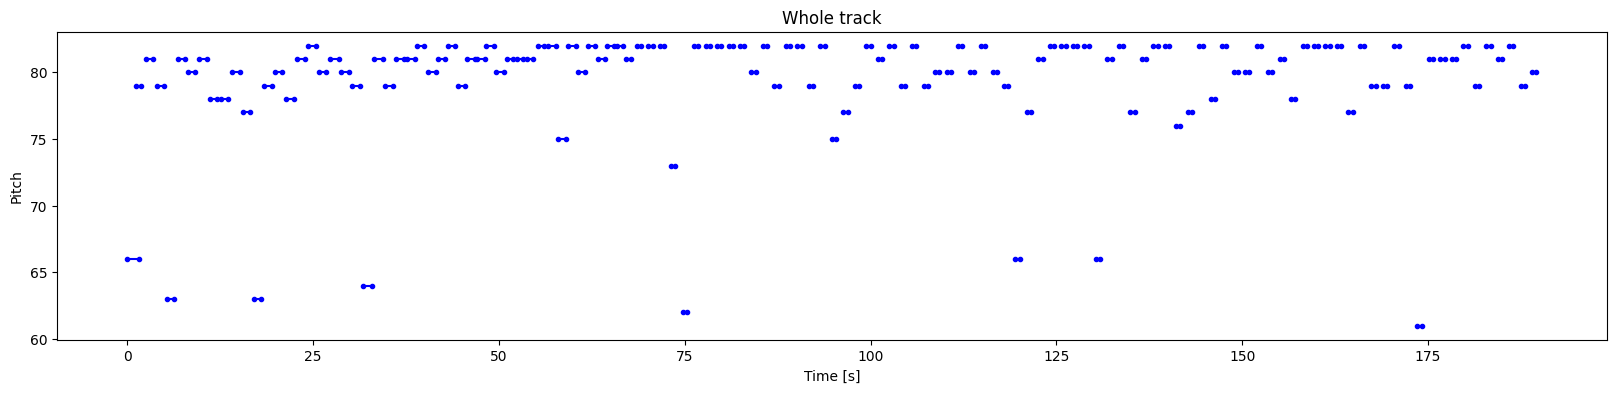

In [137]:
plot_piano_roll(generated_notes)

Check the distributions of `pitch`, `step` and `duration`.

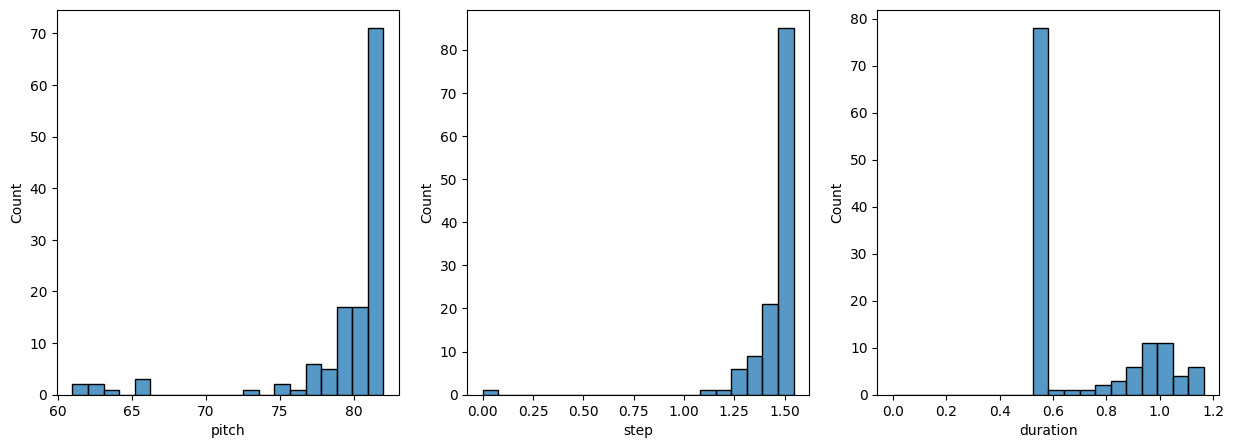

In [138]:
plot_distributions(generated_notes)

Since there is a feedback loop between the model's outputs and inputs, the model tends to generate similar sequences of outputs to reduce the loss.
This is particularly relevant for `step` and `duration`, which uses the MSE loss.
For `pitch`, can increase the randomness by increasing the `temperature` in `predict_next_note`.
